In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
from pathlib import Path
import matplotlib.patches as patches

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")


# Set figure parameters
fig_width = 3.25 #ECS spec is 3.25" width
fig_width_2col_inches = 7
fig_width_3col_inches = 10
fig_height = (3/4)*fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 8
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['xtick.bottom'] = False
rcParams['ytick.direction'] = 'in' 



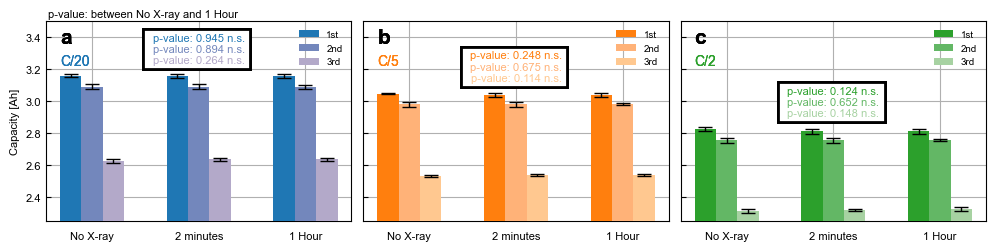

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# 엑셀 파일 경로
file_path = 'capa_op_dataframe.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path)

# 데이터를 c-rate, group 별로 나누기
c_rates = ['C/20', 'C/5', 'C/2']
groups = ['No X-ray', '2 minutes', '1 Hour']

# 색상 스킴
colors_1st = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
colors_2nd = ['#7387bc', '#ffb278', '#63b765']  
colors_3rd = ['#b3a9c9', '#ffc890', '#a7d2a2']  

# 서브플롯 생성하기
fig, axes = plt.subplots(1, 3, figsize=(fig_width_3col_inches, fig_height), sharey=True)
bar_width = 0.2

for i, c_rate in enumerate(c_rates):
    subset = df[df['c-rate'] == c_rate]
    means_1st = subset[subset['order'] == '1st'].groupby('group')['capacity'].mean()
    means_2nd = subset[subset['order'] == '2nd'].groupby('group')['capacity'].mean()
    means_3rd = subset[subset['order'] == '3rd'].groupby('group')['capacity'].mean()
    errors_1st = subset[subset['order'] == '1st'].groupby('group')['capacity'].std()
    errors_2nd = subset[subset['order'] == '2nd'].groupby('group')['capacity'].std()
    errors_3rd = subset[subset['order'] == '3rd'].groupby('group')['capacity'].std()
    indices = np.arange(len(groups))

    axes[i].grid()  # 그리드 설정

    rect = patches.Rectangle((0.68, 3.2), 1, 0.25, linewidth=2, edgecolor='k', facecolor='white', zorder=2)
    axes[0].add_patch(rect)
    rect = patches.Rectangle((0.68, 3.09), 1, 0.25, linewidth=2, edgecolor='k', facecolor='white', zorder=2)
    axes[1].add_patch(rect)
    rect = patches.Rectangle((0.68, 2.87), 1, 0.25, linewidth=2, edgecolor='k', facecolor='white', zorder=2)
    axes[2].add_patch(rect)

    bars_1st = axes[i].bar(indices, means_1st[groups], bar_width, yerr=errors_1st[groups], label='1st', color=colors_1st[i], capsize=5, zorder=3)
    bars_2nd = axes[i].bar(indices + bar_width, means_2nd[groups], bar_width, yerr=errors_2nd[groups], label='2nd', color=colors_2nd[i], capsize=5, zorder=3)
    bars_3rd = axes[i].bar(indices + 2 * bar_width, means_3rd[groups], bar_width, yerr=errors_3rd[groups], label='3rd', color=colors_3rd[i], capsize=5, zorder=3)

    # P-value 계산하기
    no_xray_1st = subset[(subset['group'] == 'No X-ray') & (subset['order'] == '1st')]['capacity']
    one_hour_1st = subset[(subset['group'] == '1 Hour') & (subset['order'] == '1st')]['capacity']
    p_value_1st = ttest_ind(no_xray_1st, one_hour_1st).pvalue

    no_xray_2nd = subset[(subset['group'] == 'No X-ray') & (subset['order'] == '2nd')]['capacity']
    one_hour_2nd = subset[(subset['group'] == '1 Hour') & (subset['order'] == '2nd')]['capacity']
    p_value_2nd = ttest_ind(no_xray_2nd, one_hour_2nd).pvalue

    no_xray_3rd = subset[(subset['group'] == 'No X-ray') & (subset['order'] == '3rd')]['capacity']
    one_hour_3rd = subset[(subset['group'] == '1 Hour') & (subset['order'] == '3rd')]['capacity']
    p_value_3rd = ttest_ind(no_xray_3rd, one_hour_3rd).pvalue

    # p-value에 따라 * 추가하기
    def significance_marker(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'n.s.'

    sig_1st = significance_marker(p_value_1st)
    sig_2nd = significance_marker(p_value_2nd)
    sig_3rd = significance_marker(p_value_3rd)

    # 그래프에 P-value 추가하기
    axes[i].text(1 + bar_width, max(means_1st.max(), means_2nd.max(), means_3rd.max()) + 0.205, f'p-value: {p_value_1st:.3f} {sig_1st}', ha='center', va='bottom', color=colors_1st[i], zorder=5)
    axes[i].text(1 + bar_width, max(means_1st.max(), means_2nd.max(), means_3rd.max()) + 0.135, f'p-value: {p_value_2nd:.3f} {sig_2nd}', ha='center', va='bottom', color=colors_2nd[i], zorder=5)
    axes[i].text(1 + bar_width, max(means_1st.max(), means_2nd.max(), means_3rd.max()) + 0.065, f'p-value: {p_value_3rd:.3f} {sig_3rd}', ha='center', va='bottom', color=colors_3rd[i], zorder=5)

    axes[i].set_xticks(indices + bar_width)
    axes[i].set_xticklabels(groups)
    axes[i].set_ylim([2.25, 3.5])  # y축 범위 설정

    axes[i].legend()
    if i == 0:
        axes[i].set_ylabel('Capacity [Ah]')

# 그래프 왼쪽 상단에 설명 텍스트 추가
    axes[0].text(-0.1, 3.4, 'a', fontsize=15, fontweight='bold', ha='left', va='center')
    axes[1].text(-0.1, 3.4, 'b', fontsize=15, fontweight='bold', ha='left', va='center')
    axes[2].text(-0.1, 3.4, 'c', fontsize=15, fontweight='bold', ha='left', va='center')

    axes[0].text(-0.1, 3.25, 'C/20', color= '#1f77b4', fontsize=10, ha='left', va='center')
    axes[1].text(-0.1, 3.25, 'C/5', color= '#ff7f0e', fontsize=10, ha='left', va='center')
    axes[2].text(-0.1, 3.25, 'C/2', color= '#2ca02c', fontsize=10, ha='left', va='center')
plt.figtext(0.05, 1.0, 'p-value: between No X-ray and 1 Hour', fontsize=8, ha='left', va='top')

plt.savefig("fig3.pdf", dpi=300, bbox_inches="tight", format="pdf")

plt.tight_layout()
plt.show()